<a href="https://colab.research.google.com/github/DanielPauliuchenka/SnakeAIGame/blob/main/chest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ashery_chexpert_path = kagglehub.dataset_download('ashery/chexpert')

print('Data source import complete.')


Data source import complete.


# Prerequisites

In [30]:
!pip install barbar

In [31]:
import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


# Pre-define Value

In [32]:
Traindata = pd.read_csv('/kaggle/input/chexpert/train.csv')
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images

In [33]:
Traindata = Traindata.fillna(0)
Traindata = Traindata.replace(-1,0)

In [34]:
# Traindata.columns

In [35]:
Traindata=Traindata.drop(['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Other', 'Fracture',
       'Support Devices'],axis=1)

In [36]:
Traindata = Traindata[~((Traindata['No Finding'] == 0) & (Traindata['Pleural Effusion'] == 0))]

Traindata = Traindata[500:]
Traindata.to_csv('/kaggle/working/train_mod.csv', index = False)
print("Train data length:", len(Traindata))

Train data length: 93373


In [37]:

Validdata = pd.read_csv('/kaggle/input/chexpert/valid.csv')
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images

Validdata = Validdata.fillna(0)
Validdata = Validdata.replace(-1,0)
Validdata=Validdata.drop(['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Other', 'Fracture',
       'Support Devices'],axis=1)
Validdata = Validdata[~((Validdata['No Finding'] == 0) & (Validdata['Pleural Effusion'] == 0))]

Validdata.to_csv('/kaggle/working/valid_mod.csv', index = False)
print("Valid data length:", len(Validdata))


Valid data length: 90


In [38]:

Testdata = Traindata.head(500) # use first 500 training data as test data (obs ratio is almost same!)
Testdata.to_csv('/kaggle/working/test_mod.csv', index = False)
print("Test data length:", len(Testdata))
# '''
pathFileTrain = '/kaggle/working/train_mod.csv'
pathFileValid = '/kaggle/working/valid_mod.csv'
pathFileTest = '/kaggle/working/test_mod.csv'

# Neural network parameters:
nnIsTrained = False     # pre-trained using ImageNet
nnClassCount = 2      # dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
# class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
#                'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
#                'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
class_names = ['No Finding', 'Pleural Effusion']

Test data length: 500


In [39]:
Traindata.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Pleural Effusion'],
      dtype='object')

# Create a Dataset

In [40]:
class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform = None, policy = "ones"):
        """
        data_PATH: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels.
        """
        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]

                for i in range(2):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
#                         elif a == -1:
#                             if policy == "ones":
#                                 label[i] = 1
#                             elif policy == "zeroes":
#                                 label[i] = 0
#                             else:
#                                 label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0

                image_names.append(image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        image_name = self.image_names[index]
        image_name = image_name.replace("CheXpert-v1.0-small","/kaggle/input/chexpert" )
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

# Load Datasets

In [41]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

transformList.append(transforms.Resize((imgtransCrop, imgtransCrop))) # 224
# transformList.append(transforms.RandomResizedCrop(imgtransCrop))
# transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
# transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

# Load dataset
datasetTrain = CheXpertDataSet(pathFileTrain, transformSequence, policy = "ones")
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid, transformSequence)
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest, transformSequence, policy = "ones")
print("Test data length:", len(datasetTest))

Train data length: 93373
Valid data length: 90
Test data length: 500


# Create train and test Models

In [42]:
class CheXpertTrainer():

    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint):
        optimizer = optim.Adam(model.parameters(), lr = 0.0001, # setting optimizer & scheduler
                               betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)
        loss = torch.nn.BCELoss() # setting loss function

        if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        # Train the network
        lossMIN = 100000
        train_start = []
        train_end = []
        for epochID in range(0, trMaxEpoch):
            train_start.append(time.time()) # training starts
            losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            train_end.append(time.time()) # training ends
            lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            print("Training loss: {:.3f},".format(losst), "Valid loss: {:.3f}".format(lossv))

            if lossv < lossMIN:
                lossMIN = lossv
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(),
                            'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()},
                           'm-epoch_FL' + str(epochID + 1) + '.pth.tar')
                print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(lossv))
            else:
                print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(lossv))

        train_time = np.array(train_end) - np.array(train_start)
        print("Training time for each epoch: {} seconds".format(train_time.round(0)))
        params = model.state_dict()
        return params


    def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
        losstrain = 0
        model.train()

        for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):

            varTarget = target.cuda(non_blocking = True)
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)

            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()

            losstrain += lossvalue.item()

        return losstrain / len(dataLoaderTrain)


    def epochVal(model, dataLoaderVal, optimizer, epochMax, classCount, loss):
        model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):

                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)

                lossVal += loss(varOutput, target)

        return lossVal / len(dataLoaderVal)


    def computeAUROC(dataGT, dataPRED, classCount):
        # Computes area under ROC curve
        # dataGT: ground truth data
        # dataPRED: predicted data
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()

        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC


    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
        cudnn.benchmark = True

        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()

        model.eval()

        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)

                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
#         outGT = outGT.cpu().numpy()
#         outPRED = outPRED.cpu().numpy()
#         for i in range(nnClassCount):
#             print("*"*20)
#             print(confusion_matrix(outGT[:, i], outPRED[:, i]))

        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean ', aurocMean)

        for i in range (0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])

        return outGT, outPRED

# Define the Model

In [43]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

# Train the model with Federated Learning

In [44]:
Traindata.shape

(93373, 7)

In [45]:
16000 + 13373

29373

In [46]:
# FOR MULTIPLE COMMUNICATION ROUNDS


'''
# Divide datasetTrain_ex
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5, dataleft = random_split(datasetTrain,
                                                                                                        [100, 100, 100, 100, 100,
                                                                                                         len(datasetTrain) - 500])
'''
# Divide datasetTrain_real
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5 = random_split(datasetTrain,
                                                                                              [29373, 16000, 16000, 16000, 16000])


# Define 5 DataLoaders
dataLoaderTrain_1 = DataLoader(dataset = datasetTrain_1, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_2 = DataLoader(dataset = datasetTrain_2, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_3 = DataLoader(dataset = datasetTrain_3, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_4 = DataLoader(dataset = datasetTrain_4, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_5 = DataLoader(dataset = datasetTrain_5, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)

# Define Valid and Test DataLoaders
dataLoaderVal = DataLoader(dataset = datasetValid, batch_size = trBatchSize,
                           shuffle = False, num_workers = 2, pin_memory = True)
dataLoaderTest = DataLoader(dataset = datasetTest, num_workers = 2, pin_memory = True)

In [47]:
com_round = 1
fraction = 1.0
epoch = 2
batch = 48
num_clients = 4

In [48]:
dT = [datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5]
dLT = [dataLoaderTrain_1, dataLoaderTrain_2, dataLoaderTrain_3, dataLoaderTrain_4, dataLoaderTrain_5]

model = DenseNet121(nnClassCount).cuda() # Step 0: Initialize global model and load the model
model = torch.nn.DataParallel(model).cuda()

for i in range(com_round):
    print("[[[ Round {} Start ]]]".format(i + 1))
    params = [None] * num_clients
    sel_clients = sorted(random.sample(range(num_clients),
                                       round(num_clients*fraction))) # Step 1: select random fraction of clients
    print("The number of clients:", len(sel_clients))
    for j in sel_clients: # Step 2: send weights to clients
        print("<< Client {} Training Start >>".format(j + 1))
        train_valid_start = time.time()
        params[j] = CheXpertTrainer.train(model, dLT[j], dataLoaderVal, # Step 3: Perform local computations
                                          nnClassCount, trMaxEpoch = epoch, checkpoint = None)
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)
        print("<< Client {} Training End: {} seconds elapsed >>".format(j + 1, client_time))

    fidx = [idx for idx in range(len(params)) if params[idx] != None][0]
    lidx = [idx for idx in range(len(params)) if params[idx] != None][-1]
    for key in params[fidx]: # Step 4: return updates to server
        weights, weightn = [], []
        for k in sel_clients:
            weights.append(params[k][key]*len(dT[k]))
            weightn.append(len(dT[k]))
        params[lidx][key] = sum(weights) / sum(weightn) # weighted averaging model weights

    model = DenseNet121(nnClassCount).cuda()
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(params[lidx]) # Step 5: server updates global state
    print("[[[ Round {} End ]]]".format(i + 1))

print("Global model trained")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[[[ Round 1 Start ]]]
The number of clients: 4
<< Client 1 Training Start >>
29373/29373: [===============================>] - ETA 3.9s
Training loss: 0.286, Valid loss: 0.241
Epoch 1 [save] loss = tensor(0.2412, device='cuda:0')
29373/29373: [===============================>] - ETA 0.6s
Training loss: 0.243, Valid loss: 0.207
Epoch 2 [save] loss = tensor(0.2070, device='cuda:0')
Training time for each epoch: [312. 300.] seconds
<< Client 1 Training End: 614 seconds elapsed >>
<< Client 2 Training Start >>
16000/16000: [===============================>] - ETA 0.4s
Training loss: 0.229, Valid loss: 0.238
Epoch 1 [save] loss = tensor(0.2379, device='cuda:0')
16000/16000: [===============================>] - ETA 0.3s
Training loss: 0.217, Valid loss: 0.210
Epoch 2 [save] loss = tensor(0.2103, device='cuda:0')
Training time for each epoch: [165. 163.] seconds
<< Client 2 Training End: 330 seconds elapsed >>
<< Client 3 Training Start >>
16000/16000: [===============================>] - ETA

In [50]:
save_path = "method2_resnet50.pth"
# Save the trained model
torch.save(model.state_dict(), save_path)


In [53]:
# test time only
model = DenseNet121(nnClassCount).cuda()
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load("/content/m-epoch_FL2.pth.tar")['state_dict'])
model.eval()
# Step 5: server updates global state
# print("[[[ Round {} End ]]]".format(i + 1))

DataParallel(
  (module): DenseNet121(
    (densenet121): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _Dens

# Test and ROC Curves

In [54]:
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, None, class_names)

AUROC mean  0.9553420889164966
No Finding   0.9554086431804065
Pleural Effusion   0.9552755346525867


In [55]:
cudnn.benchmark = True


if use_gpu:
    outGT = torch.FloatTensor().cuda()
    outPRED = torch.FloatTensor().cuda()
else:
    outGT = torch.FloatTensor()
    outPRED = torch.FloatTensor()

model.eval()

with torch.no_grad():
    for i, (input, target) in enumerate(dataLoaderTest):

        target = target.cuda()
        outGT = torch.cat((outGT, target), 0).cuda()

        bs, c, h, w = input.size()
        varInput = input.view(-1, c, h, w)

        out = model(varInput)
        outPRED = torch.cat((outPRED, out), 0)

In [56]:
for (x,y) in outPRED:
    if x > 0.5:
        x

In [57]:
0.9464+0.0544

1.0008

In [58]:
outGT.shape

torch.Size([500, 2])

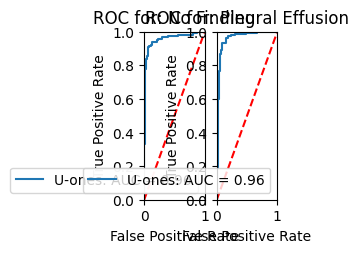

In [59]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:,i], outPRED.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)

    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (30, 10)

plt.savefig("ROC.png", dpi = 1000)
plt.show()

# Computational Stats

In [ ]:
# Took about 20 min per client(3 epoch) for a single round.
# Took about 60 min per clinet(3 epoch) for whole training.